In [1]:
!pip install split_folders
import splitfolders
splitfolders.ratio("/kaggle/input/state-farm-distracted-driver-detection/imgs/train", output="/kaggle/working/", seed=1337, ratio=(.1, .1, .8), group_prefix=None) # default values

Copying files: 22424 files [03:20, 112.06 files/s]


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

In [3]:
import os
NUM_CLASSES = len(os.listdir(r'./test'))

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2237 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.


In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6

md = DenseNet201(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
# summarize layers
print(model.summary())
# plot graph
#plot_model(model, to_file='shared_input_layer.png')

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 10)                19210     
Total params: 18,341,194
Trainable params: 18,112,138
Non-trainable params: 229,056
_________________________________________________________________
None


In [5]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=10)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
93/93 [==============================] - 70s 461ms/step - loss: 2.2099 - accuracy: 0.2279 - val_loss: 1.6479 - val_accuracy: 0.5108
Epoch 2/10
93/93 [==============================] - 37s 403ms/step - loss: 1.0939 - accuracy: 0.8615 - val_loss: 0.8878 - val_accuracy: 0.8557
Epoch 3/10
93/93 [==============================] - 37s 403ms/step - loss: 0.5612 - accuracy: 0.9781 - val_loss: 0.5335 - val_accuracy: 0.9400
Epoch 4/10
93/93 [==============================] - 38s 406ms/step - loss: 0.3202 - accuracy: 0.9930 - val_loss: 0.3629 - val_accuracy: 0.9592
Epoch 5/10
93/93 [==============================] - 37s 401ms/step - loss: 0.2052 - accuracy: 0.9976 - val_loss: 0.2688 - val_accuracy: 0.9695
Epoch 6/10
93/93 [==============================] - 37s 398ms/step - loss: 0.1330 - accuracy: 0.9998 - val_loss: 0.2135 - val_accuracy: 0.9700
Epoch 7/10
93/93 [==============================] - 37s 397ms/step - loss: 0.0874 - accuracy: 1.0000 - val_loss: 0.1791 - val_accuracy: 0.9718

In [6]:
# serialize model to JSON
model_json = model.to_json()
with open("DenseNet201.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("DenseNet201.h5")
print("Saved model to disk")

Saved model to disk


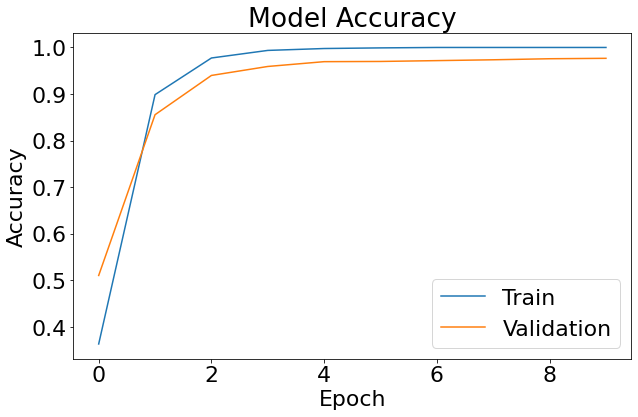

<Figure size 432x288 with 0 Axes>

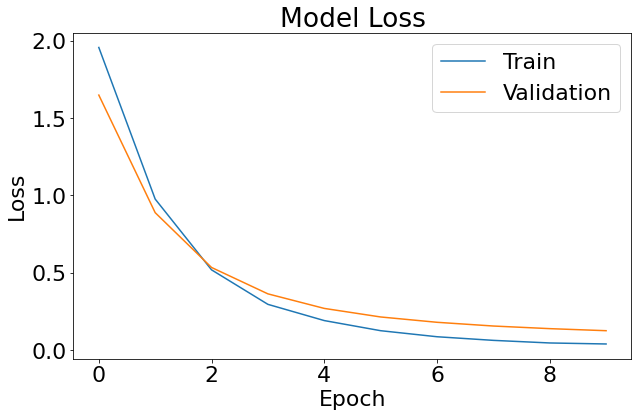

In [7]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.figure(2)
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Found 17950 images belonging to 10 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


747/747 [==============================] - 114s 149ms/step
                Filename Predictions
0      c0/img_100026.jpg          c0
1      c0/img_100050.jpg          c0
2      c0/img_100074.jpg          c0
3       c0/img_10012.jpg          c0
4      c0/img_100191.jpg          c0
...                  ...         ...
17945   c9/img_99740.jpg          c0
17946   c9/img_99761.jpg          c9
17947   c9/img_99801.jpg          c8
17948   c9/img_99927.jpg          c9
17949    c9/img_9993.jpg          c9

[17950 rows x 2 columns]
17562 388
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1993
           1       0.98      0.97      0.98      1815
           2       1.00      0.99      1.00      1855
           3       0.99      0.99      0.99      1878
           4       0.98      1.00      0.99      1862
           5       1.00      0.99      0.99      1850
           6       0.99      0.99      0.99      1861
           7       0.98     

<AxesSubplot:>

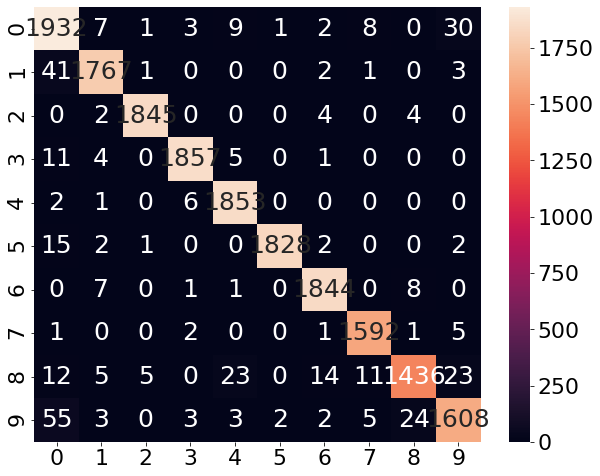

In [8]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

In [9]:
original = np.argmax(test_y,axis=1)

pred2 = pred
for i in range(len(pred2)):
    pred2[i][predicted_class_indices[i]]=0

predicted_class_indices2 = np.argmax(pred,axis=1)

pred3 = pred2
for i in range(len(pred3)):
    pred3[i][predicted_class_indices2[i]]=0

predicted_class_indices3 = np.argmax(pred2,axis=1)

predicted_class_indices, predicted_class_indices2, predicted_class_indices3, original

(array([0, 0, 0, ..., 8, 9, 9]),
 array([9, 9, 9, ..., 9, 1, 7]),
 array([3, 5, 1, ..., 6, 0, 0]),
 array([0, 0, 0, ..., 9, 9, 9]))

In [10]:
top2 = []
for i in range(len(original)):
    if predicted_class_indices[i]==original[i] or predicted_class_indices2[i]==original[i]:
        top2.append(original[i])
    else:
        top2.append(predicted_class_indices[i])
top2 = np.array(top2)

top3 = []
for i in range(len(original)):
    if predicted_class_indices[i]==original[i] or predicted_class_indices2[i]==original[i] or predicted_class_indices3[i]==original[i]:
        top3.append(original[i])
    else:
        top3.append(predicted_class_indices[i])
top3 = np.array(top3)

top2, top3

(array([0, 0, 0, ..., 9, 9, 9]), array([0, 0, 0, ..., 9, 9, 9]))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1993
           1       0.99      0.98      0.99      1815
           2       1.00      1.00      1.00      1855
           3       1.00      1.00      1.00      1878
           4       0.99      1.00      1.00      1862
           5       1.00      0.99      0.99      1850
           6       1.00      1.00      1.00      1861
           7       1.00      1.00      1.00      1602
           8       1.00      0.98      0.99      1529
           9       0.99      0.99      0.99      1705

    accuracy                           0.99     17950
   macro avg       0.99      0.99      0.99     17950
weighted avg       0.99      0.99      0.99     17950

99.18105849582173
Class  0  Accuracy:  0.9914701455092825
Class  1  Accuracy:  0.9790633608815427
Class  2  Accuracy:  0.9967654986522911
Class  3  Accuracy:  0.9952076677316294
Class  4  Accuracy:  0.9973147153598282
Class  5  Accuracy:  0.

<AxesSubplot:>

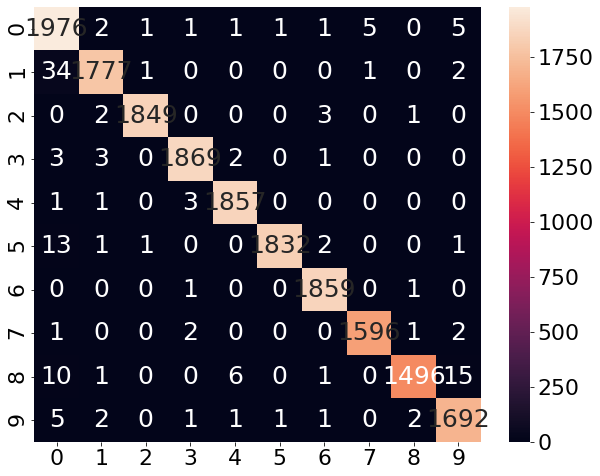

In [11]:
pred_y = top2
test_y = original
from keras.utils import np_utils
#test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
#pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y, pred_y)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1993
           1       1.00      0.99      0.99      1815
           2       1.00      1.00      1.00      1855
           3       1.00      1.00      1.00      1878
           4       1.00      1.00      1.00      1862
           5       1.00      0.99      1.00      1850
           6       1.00      1.00      1.00      1861
           7       1.00      1.00      1.00      1602
           8       1.00      0.98      0.99      1529
           9       0.99      1.00      0.99      1705

    accuracy                           0.99     17950
   macro avg       0.99      0.99      0.99     17950
weighted avg       0.99      0.99      0.99     17950

99.45403899721448
Class  0  Accuracy:  0.9954841946813848
Class  1  Accuracy:  0.9873278236914601
Class  2  Accuracy:  0.9973045822102425
Class  3  Accuracy:  0.9968051118210862
Class  4  Accuracy:  0.9973147153598282
Class  5  Accuracy:  0.

<AxesSubplot:>

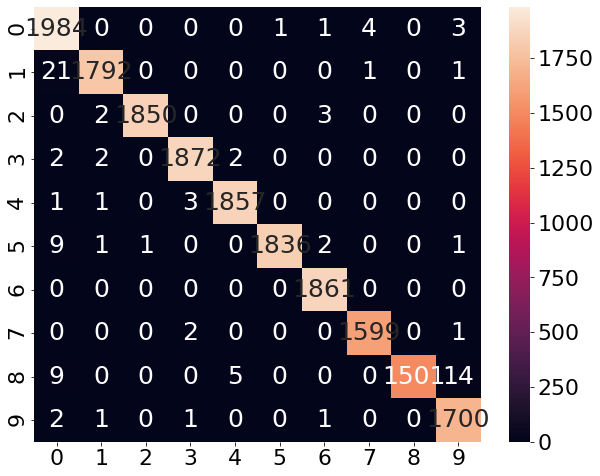

In [12]:
pred_y = top3
test_y = original
from keras.utils import np_utils
#test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
#pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y, pred_y)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,8))
sns.heatmap(c, annot=True, annot_kws={"size": 25}, fmt='d')

82526208/82524592 [==============================] - 1s 0us/step


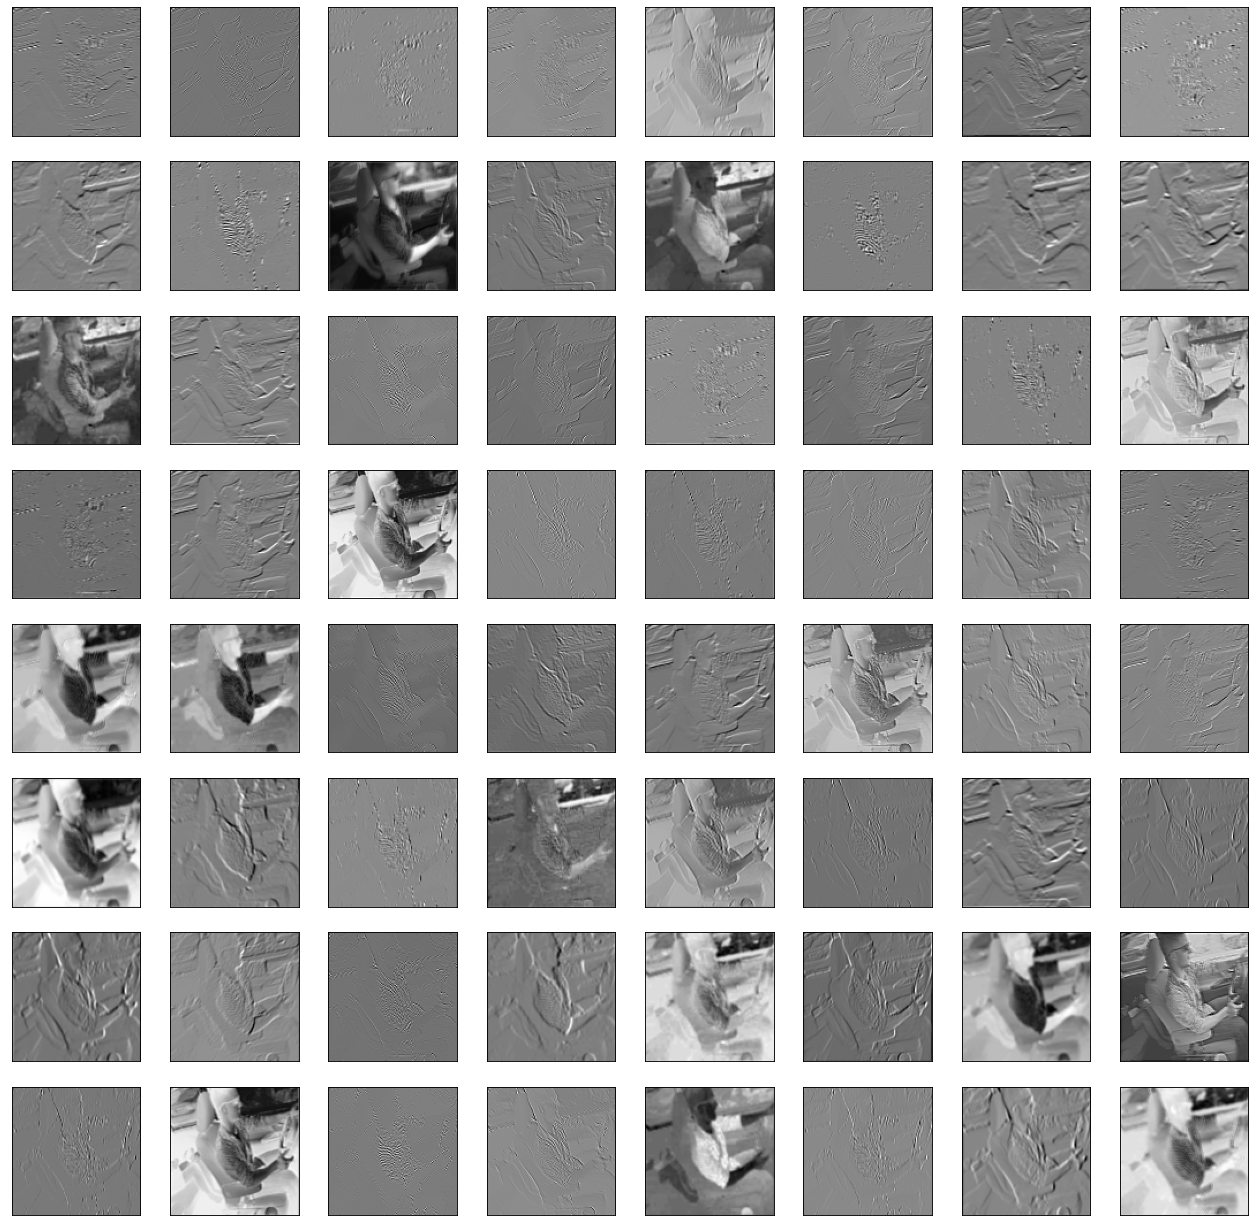

In [13]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[2].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[3].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[4].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[5].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[6].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[7].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[704].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(40):
	for _ in range(48):
		# specify subplot and turn of axis
		ax = pyplot.subplot(40, 48, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()